In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE

In [103]:
df = pd.read_csv('estadisticas_fantasy.csv')
print(df)

     Unnamed: 0          Nombre Posición        Equipo  Puntos  \
0             0     Lewandowski       DL  FC Barcelona     146   
1             1        Raphinha       DL  FC Barcelona     143   
2             2    Lamine Yamal       DL  FC Barcelona     137   
3             3    Vinícius Jr.       DL   Real Madrid     118   
4             4          Mbappe       DL   Real Madrid     102   
..          ...             ...      ...           ...     ...   
585         585         Vallejo       DF   Real Madrid      -1   
586         586          Adrián       PO    Real Betis      -2   
587         587  Rodrigo Abajas       DF   Valencia CF      -2   
588         588     Juan Carlos       PO        Girona      -3   
589         589        R Chasco       DF    Valladolid      -3   

     Media Puntos Relevo  Puntos Relevo Precio Actual Precio Inicial  Media  \
0                   2.85             37   127.371.980    127.397.088  11.23   
1                   3.23             42   125.574

In [104]:
### EDA ###

In [105]:
print("num_atributs: ", len(df.keys()))
nan_columns = df.columns[df.isna().sum()>0].tolist()
print("NaNs: ", nan_columns)
print("num nans", df.isna().sum().sum())
print("Describe\n", df.describe())
print("\n\ninfo:\n", df.info())
print("\n\nnunique:\n", df.nunique())

num_atributs:  31
NaNs:  []
num nans 0
Describe
        Unnamed: 0      Puntos  Media Puntos Relevo  Puntos Relevo       Media  \
count  590.000000  590.000000           590.000000     590.000000  590.000000   
mean   294.500000   27.794915             0.893814       9.661017    2.543678   
std    170.462606   25.861069             0.795729       9.135669    2.227177   
min      0.000000   -3.000000             0.000000       0.000000   -0.330000   
25%    147.250000    7.250000             0.000000       0.000000    0.730000   
50%    294.500000   21.000000             0.750000       8.000000    2.180000   
75%    441.750000   46.000000             1.400000      15.000000    4.000000   
max    589.000000  146.000000             3.580000      43.000000   11.420000   

         Partidos      Minutos       Goles  Asistencias  Asistencias sin Gol  \
count  590.000000   590.000000  590.000000   590.000000           590.000000   
mean     9.001695   399.581356    0.479661     0.362712      

In [106]:
df.rename(columns={'Unnamed: 0': 'ID_jugador'}, inplace=True)

df['Precio Actual'] = df['Precio Actual'].str.replace('.','')
df['Precio Inicial'] = df['Precio Inicial'].str.replace('.','')

df['Precio Actual'] = df['Precio Actual'].astype(int)
df['Precio Inicial'] = df['Precio Inicial'].astype(int)

df = df[df['Posición'] != 'DT']
df.drop(columns=['Nombre'], inplace=True)
df.drop(columns=['ID_jugador'], inplace=True)
df.drop(columns=['Precio Inicial'], inplace=True) #Hem provat de modelar la diferencia i el percentatge de millora, pero no funciona gaire be

le = LabelEncoder()
# 0: Defensa 1: Davanter 2: Migcampista 3: Porter 4: DT no hi ha)
df['Posición'] = le.fit_transform(df['Posición'])
df['Equipo'] = le.fit_transform(df['Equipo'])


In [108]:
# com veiem que no hi ha gaire relacio entre la diferencia de preu i la resta de variables, fem features engineering
df['Gols_per_Minuts'] = df['Goles'] / (df['Minutos'] + 1e-9)  # Afegir 1e-9 per evitar dividir per 0
df['Assistencies_per_Partit'] = df['Asistencias'] / (df['Partidos'] + 1e-9)
df['Gols_Assistencies'] = df['Goles'] + df['Asistencias']
df['Percentatge_gols'] = df['Goles']/df.groupby('Equipo')['Goles'].sum()[df['Equipo'].values].values

0      0.358974
1      0.179487
2      0.128205
3      0.296296
4      0.222222
         ...   
585    0.000000
586    0.000000
587    0.000000
588    0.000000
589    0.000000
Name: Percentatge_gols, Length: 566, dtype: float64


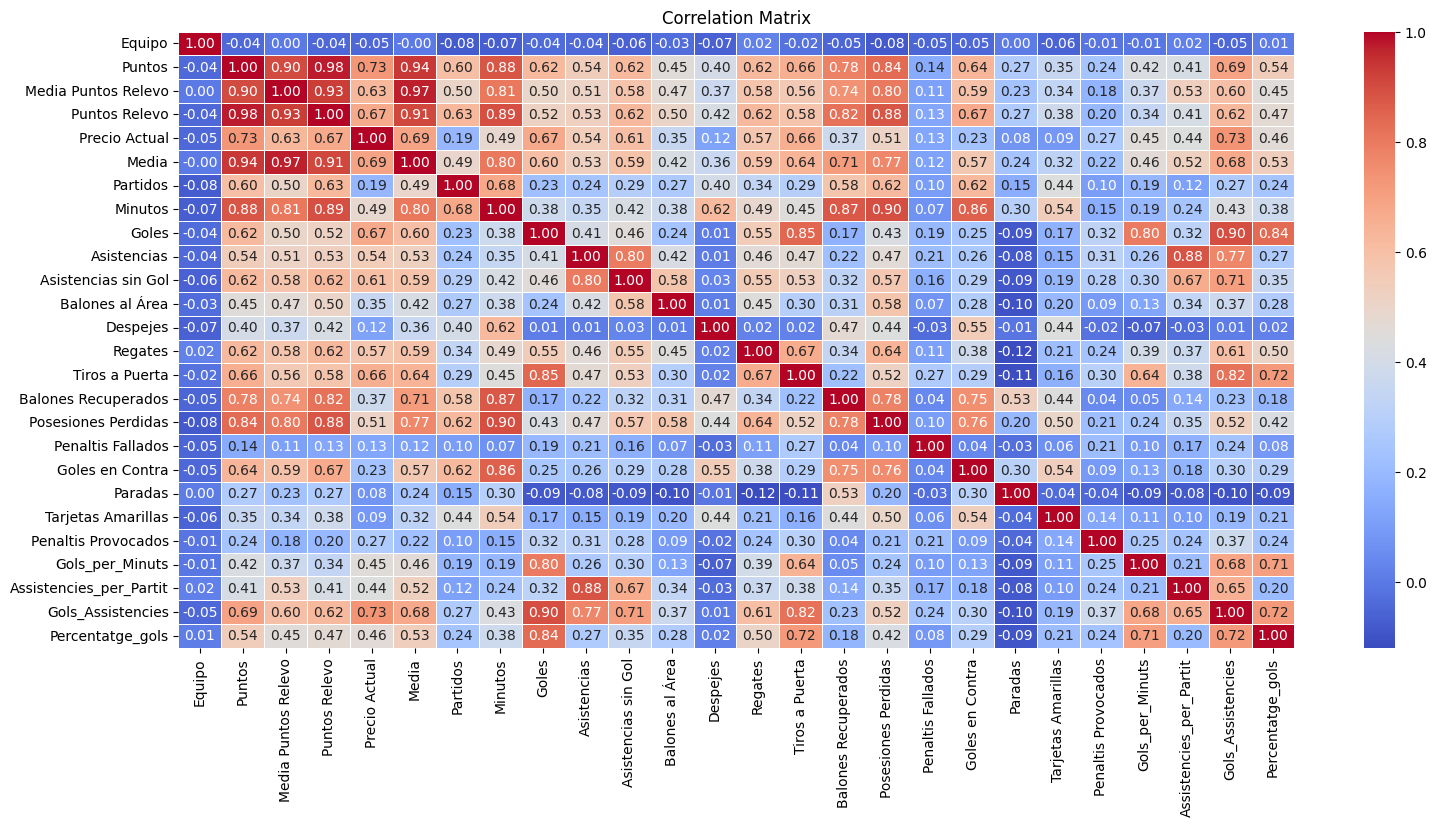

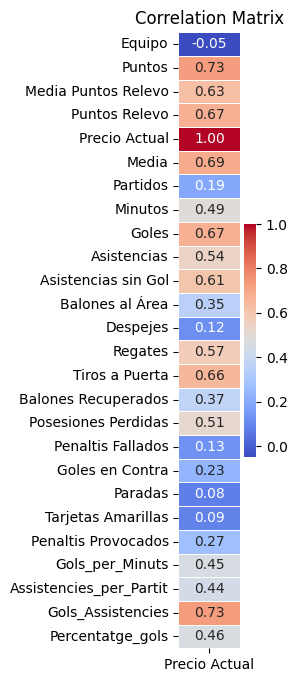

In [126]:
corr_matrix = df.corr()
corr_dif_preu = corr_matrix[['Precio Actual']]

plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')

plt.figure(figsize=(1,8))
sns.heatmap(corr_dif_preu, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [120]:
target_att = 'Precio Actual'

attributes = [k for k in df.keys() if k!= target_att]
X = df[attributes].to_numpy()
y = df[[target_att]].to_numpy()


sc = StandardScaler()
X_norm = sc.fit_transform(X)
y_norm = sc.fit_transform(y)

X_train, X_test, y_train , y_test = train_test_split(X_norm,y_norm,test_size = 0.1, random_state=42)


In [110]:
lr = LinearRegression()
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)
y_pred_train = lr.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)


0.7571475463795633 0.7558275699392867


/tmp/ipykernel_7842/674296424.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'norm' will be ignored
  plt.scatter(y_train,y_pred_train, norm='Normalize')


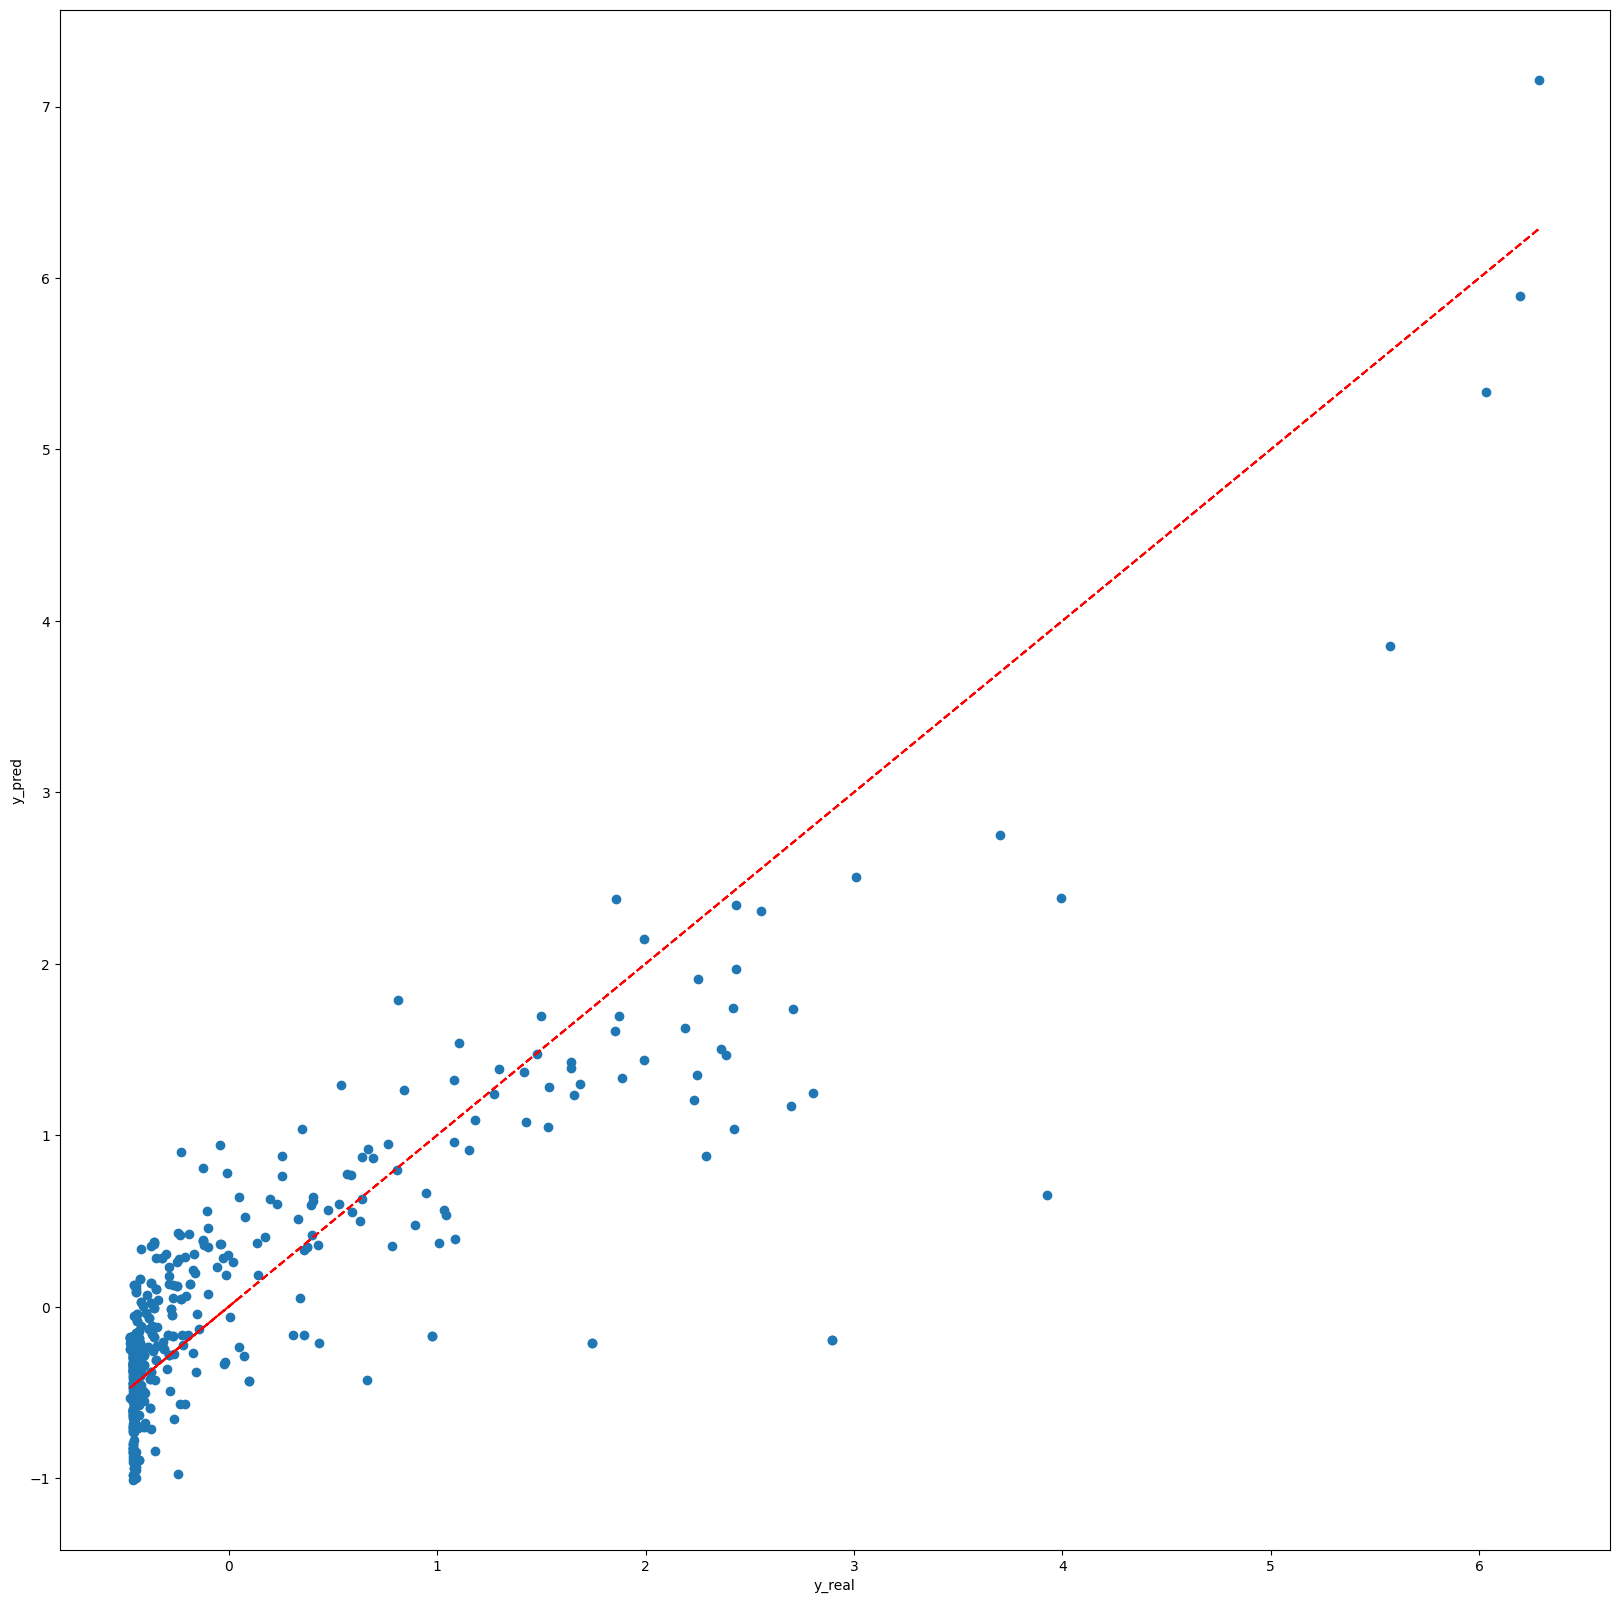

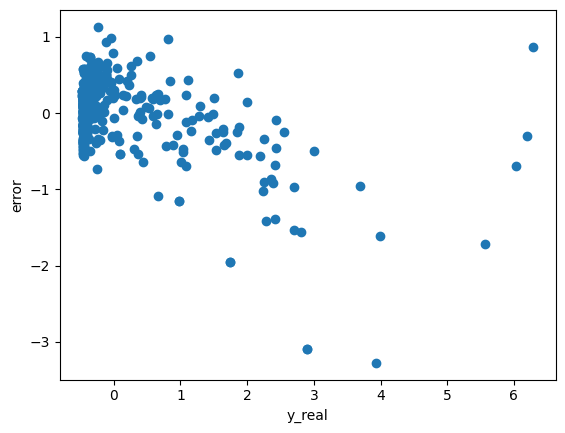

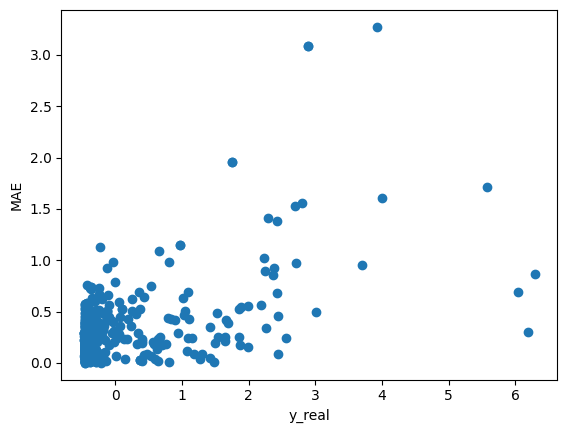

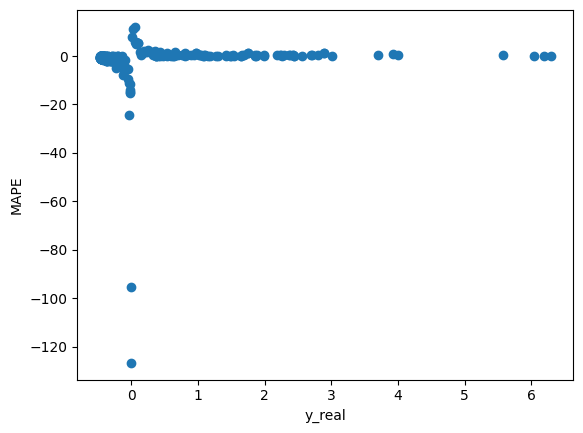

In [111]:
plt.figure(figsize=(20,20))
y_train = np.array(y_train).flatten()
y_pred_train = y_pred_train.flatten()
plt.scatter(y_train,y_pred_train, norm='Normalize')
plt.plot(y_train,y_train,'--',c = 'red')
plt.xlabel('y_real')
plt.ylabel('y_pred')
plt.show()

plt.scatter(y_train,y_pred_train-y_train)
plt.xlabel('y_real')
plt.ylabel('error')
plt.show()

plt.scatter(y_train,abs(y_pred_train-y_train))
plt.xlabel('y_real')
plt.ylabel('MAE')
plt.show()


plt.scatter(y_train,abs(y_pred_train-y_train)/y_train)
plt.xlabel('y_real')
plt.ylabel('MAPE')
plt.show()

In [112]:
lass = LassoCV(cv=5, random_state=40)
lass.fit(X_train,y_train)

y_pred = lass.predict(X_test)
y_pred_train = lass.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)
for i in range(len(attributes)):
    print(f'{attributes[i]} {lass.coef_[i]}')


0.7482719669851585 0.76821121173605
Posición -0.0277844984361042
Equipo -0.0036654436360673147
Puntos 0.5597519944824927
Media Puntos Relevo -0.14955158612219654
Puntos Relevo 0.34322451152222744
Media -0.0
Partidos -0.21038041770730878
Minutos 0.0
Goles 0.42916159859525005
Asistencias 0.0
Asistencias sin Gol 0.05101890137277022
Balones al Área 0.0
Despejes 0.005665067871840805
Regates 0.08615051921985187
Tiros a Puerta -0.010737607068198261
Balones Recuperados -0.06891211770799806
Posesiones Perdidas -0.038315444557173554
Penaltis Fallados -0.018780398807990335
Goles en Contra -0.14321151212261501
Tarjetas Rojas -0.020365021465749103
Paradas 0.010798079600049183
Penaltis Cometidos 0.009716512290025512
Tarjetas Amarillas -0.038671463729881214
Segundas Amarillas -0.017263162948687287
Penaltis Provocados 0.009901429766141412
Penaltis Parados 0.02168256702514184
Goles en Propia Puerta 0.0046676428408023805
Gols_per_Minuts -0.08403062063362708
Assistencies_per_Partit 0.0
Gols_Assistencies 

In [113]:
rid = RidgeCV(cv=5)
rid.fit(X_train,y_train)

y_pred = rid.predict(X_test)
y_pred_train = rid.predict(X_train)

r2_test = r2_score(y_test,y_pred)
r2_train = r2_score(y_train,y_pred_train)
print (r2_train,r2_test)
print(len(rid.coef_))

0.7527341498672987 0.7666568405215606
31


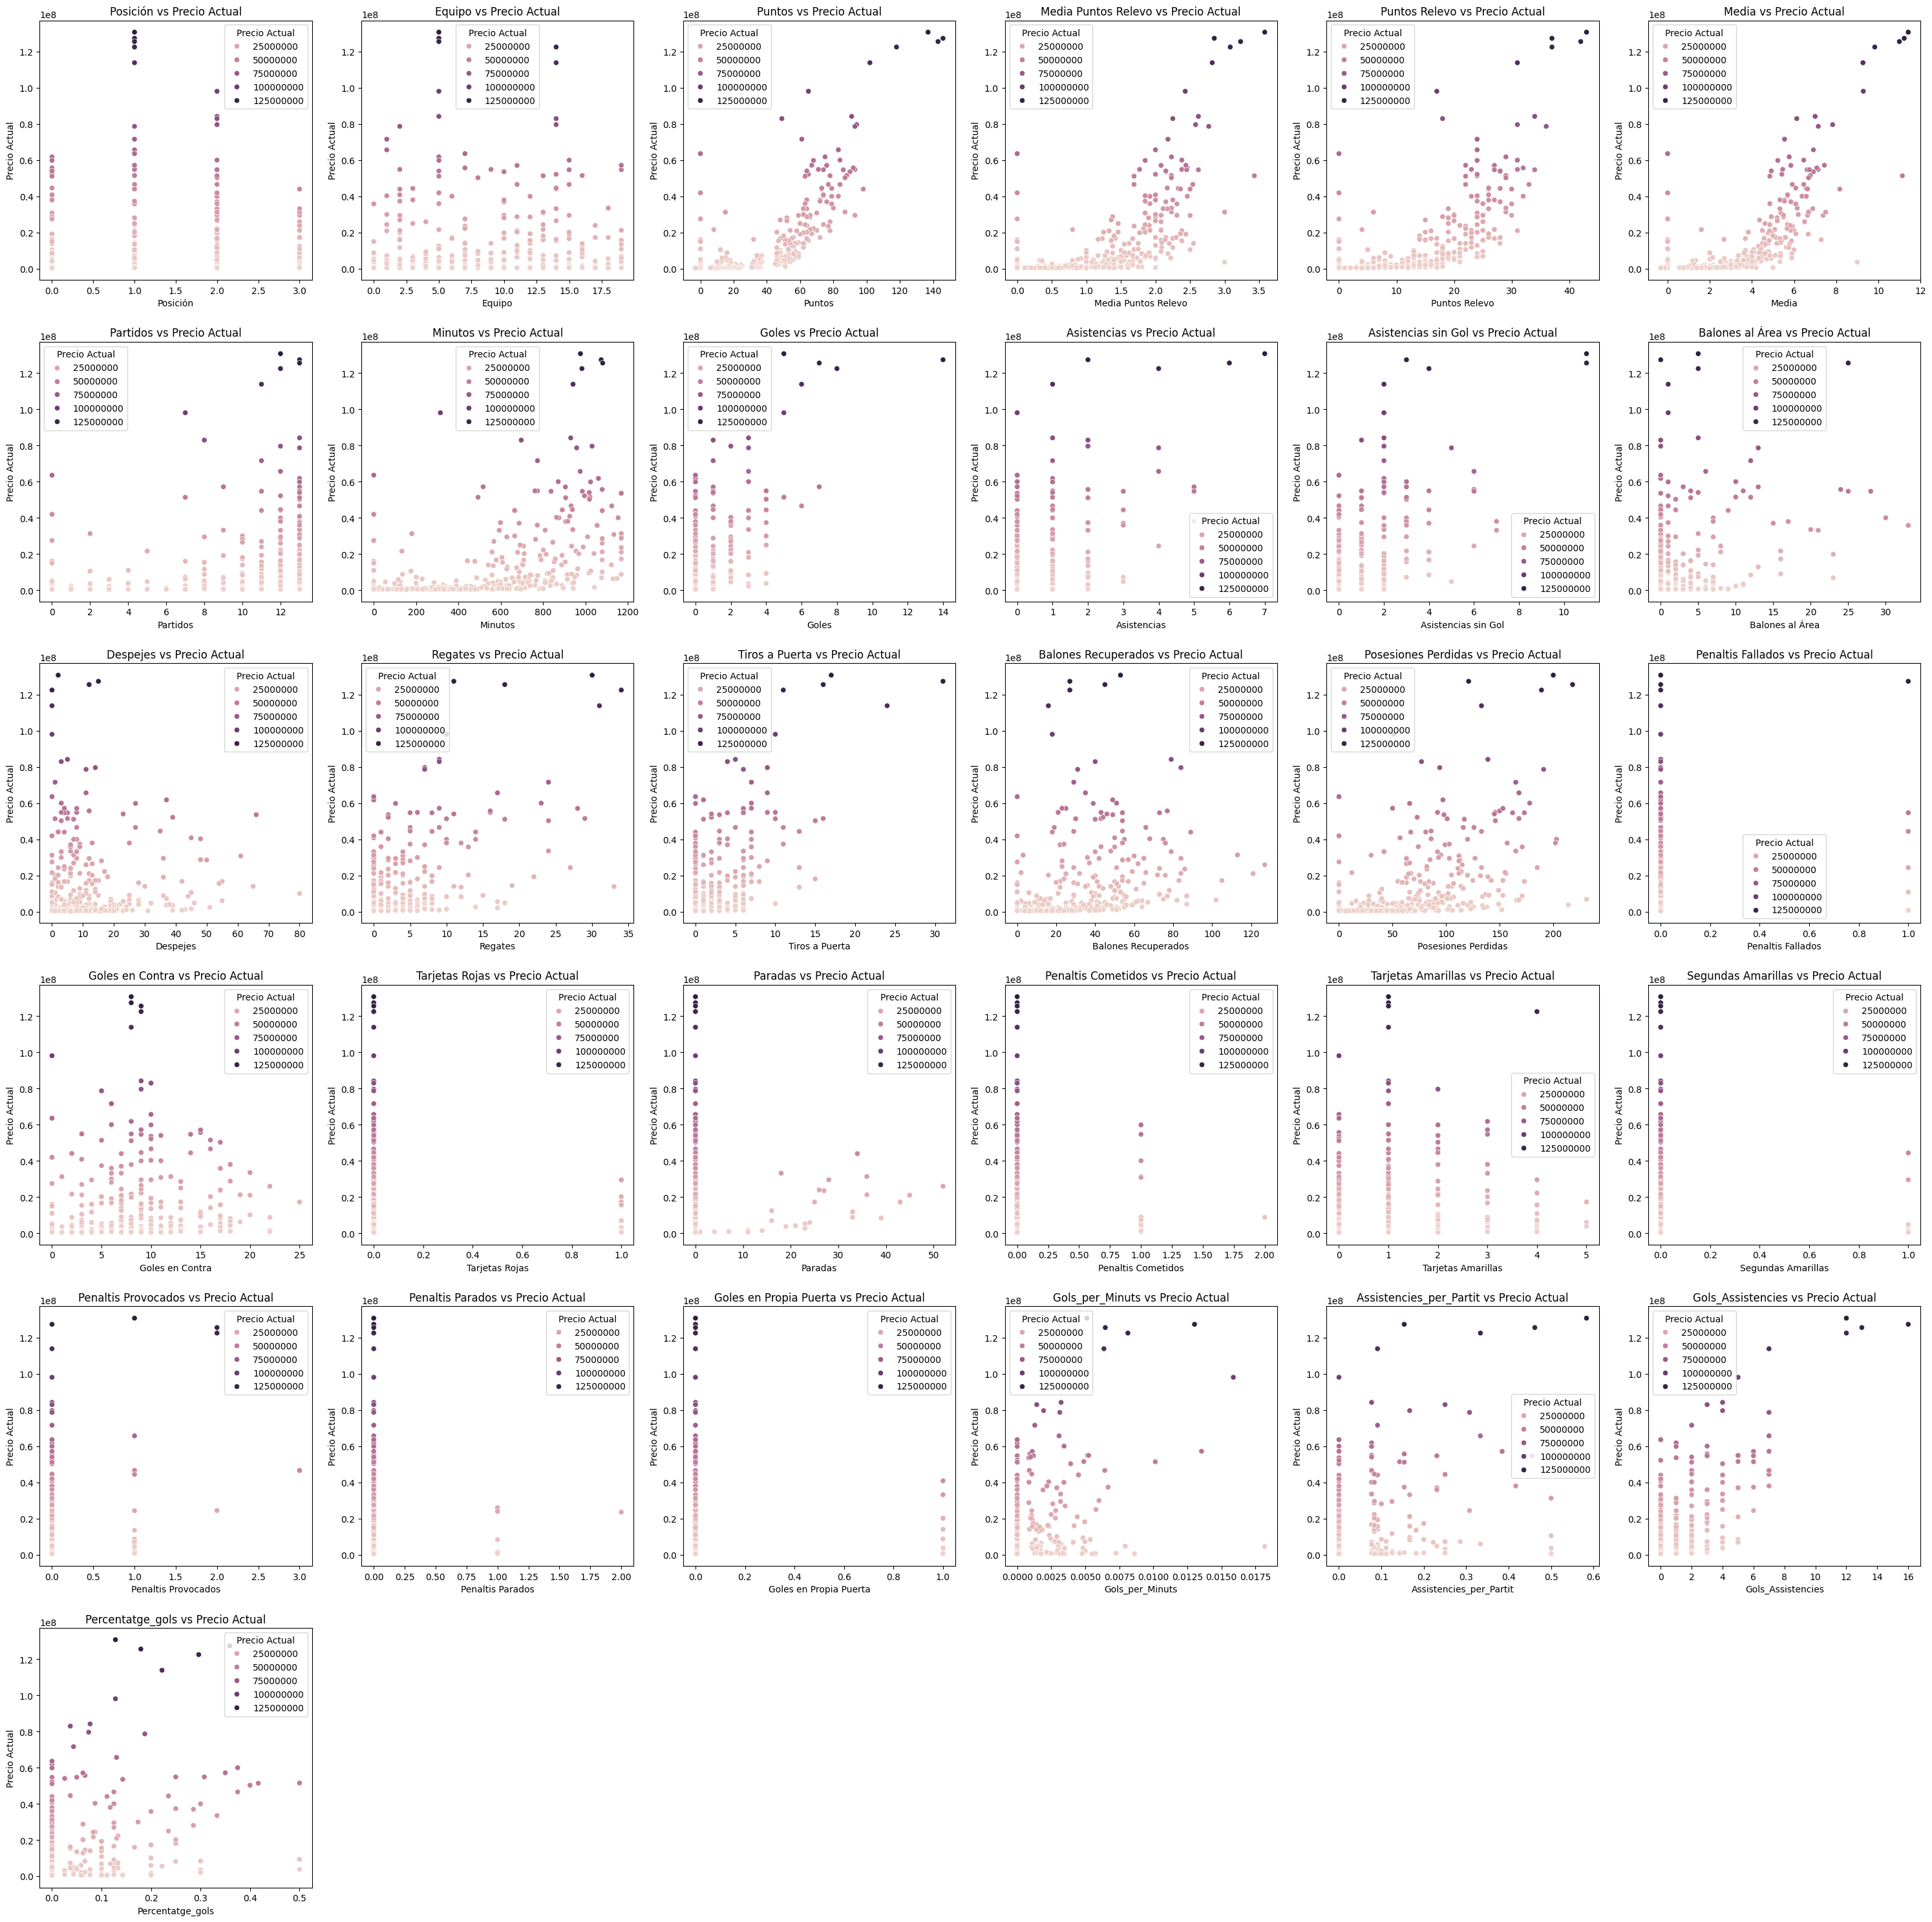

In [114]:
n = len(attributes)
rows = 6
cols = (n + rows - 1) // rows  

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))

for i, var in enumerate(attributes):
    row, col = divmod(i, cols) 
    sns.scatterplot(data=df, x=var, y=target_att, hue=target_att, ax=axes[row, col])
    axes[row, col].set_title(f'{var} vs {target_att}')

for j in range(n, rows*cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout()
plt.show()


In [125]:

# if name == "Random Forest":
#     for i in range(len(model.feature_importances_)):
#         print(f'{attributes[i]} {model.feature_importances_[i]}')   

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "LightGBM": LGBMRegressor(),
    "XGBoost": XGBRegressor(),
    "AdaBoost": AdaBoostRegressor()
}

results = {}
for name, model_f in models.items():
    model = RFE(model_f, n_features_to_select=5)
    model.fit(X, y)
    print("Características seleccionadas:", model.support_)
    # model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    results[name] = {"MAE Train": mae_train, "MAE Test": mae_test, "MSE Train": mse_train, "MSE Test": mse_test,'R2 Train': r2_train, 'R2 Test': r2_test}

results_df = pd.DataFrame(results).T
print(results_df)

Características seleccionadas: [False False False False False False False False False False False False
 False False False False  True False False False False  True  True  True
  True]


/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please ch

Características seleccionadas: [ True  True  True False  True False False False False False False False
 False False  True False False False False False False False False False
 False]
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 876
[LightGBM] [Info] Number of data points in the train set: 566, number of used features: 24
[LightGBM] [Info] Start training from score 9164694.733216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 839
[LightGBM] [Info] Number of data points in the train set: 566, number of used features: 19
[LightGBM] [Info] Start training from score 9164694.733216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 566, number of used features: 12
[LightGBM] [Info] Start training from score 9164694.733216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

Características seleccionadas: [False  True  True False  True False False False False False False False
 False False False False False False False False False False False  True
  True]


/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Ple

Características seleccionadas: [ True  True  True False  True False False False False False False False
  True False False False False False False False False False False False
 False]
                      MAE Train      MAE Test     MSE Train      MSE Test  \
Linear Regression  6.477256e+08  6.929288e+08  9.617635e+17  1.442519e+18   
Random Forest      6.365953e+06  6.688866e+06  4.708011e+13  5.095591e+13   
LightGBM           2.638328e+06  2.842488e+06  1.426447e+13  1.636179e+13   
XGBoost            1.791693e+06  1.845115e+06  8.927881e+12  7.040344e+12   
AdaBoost           8.693623e+06  8.223278e+06  8.064028e+13  7.271774e+13   

                       R2 Train       R2 Test  
Linear Regression -1.082963e+18 -7.470871e+17  
Random Forest     -5.301305e+13 -2.639030e+13  
LightGBM          -1.606205e+13 -8.473849e+12  
XGBoost           -1.005295e+13 -3.646227e+12  
AdaBoost          -9.080239e+13 -3.766086e+13  


/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hector/miniconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [118]:
# Anem a carregar-nos les columens molt relacionades entre elles i despres fem rfe per quedarnos amb les mes importatns
#df.drop(columns=['Segundas Amarillas', 'Penaltis Parados', 'Goles en Propia Puerta', 'Tarjetas Rojas', 'Posición','Penaltis Cometidos'], inplace=True)